# Make a fit over an entire region of the field

This is a complete example of a fit over an entire region of interest (ROI). The different steps covered are :

1. Extraction of a deep frame and the WCS
2. Definition of the ROI with DS9
3. Fit of a single spectrum in order to get an initial guess on the velocity of the gas
4. Fit of the entire ROI
5. Visualization of the resulting maps

In [1]:
from orcs.process import SpectralCube
import pylab as pl
import orb.utils.io
import numpy as np

In [2]:
cube = SpectralCube('/home/thomas/local/M57_SN3.merged.cm1.1.0.hdf5', debug=False)

master.11e5|WARNING| both level2 and level3 in attrs
master.11e5|INFO| Cube is level 3
master.11e5|INFO| shape: (2048, 2064, 593)
master.11e5|INFO| wavenumber calibration: True
master.11e5|INFO| flux calibration: True
master.11e5|INFO| wcs calibration: True


## Export the deep frame with its WCS to define the ROI

master.11e5|WARNING| Complex data cast to float32 (FITS format do not support complex data)
master.11e5|INFO| Data written as deep_frame.fits in 0.19 s 


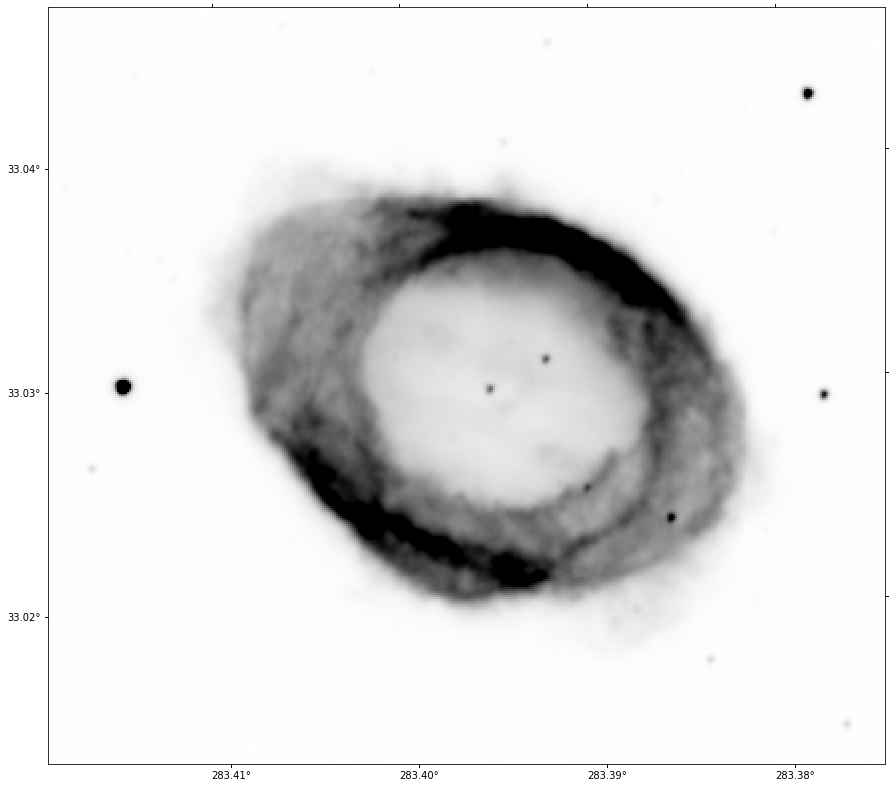

In [11]:
deep_frame = cube.get_deep_frame()
deep_frame.imshow(cmap='gray_r', perc=99.9)
pl.xlim((550,970))
pl.ylim((650,1030))
deep_frame.to_fits('deep_frame.fits')

## Use ds9 to define the ROI

from here you can use ds9 to define the region of interest on the deep frame. You can export the region in celestial or image coordinates. Note that the region can also be passed as a collection of pixel position as it is returned by a function such as numpy.nonzero(). the content of the generated ds9 region file is:

It can be plotted (for checking purpose) with pyregion (http://pyregion.readthedocs.io/en/latest/index.html) like this

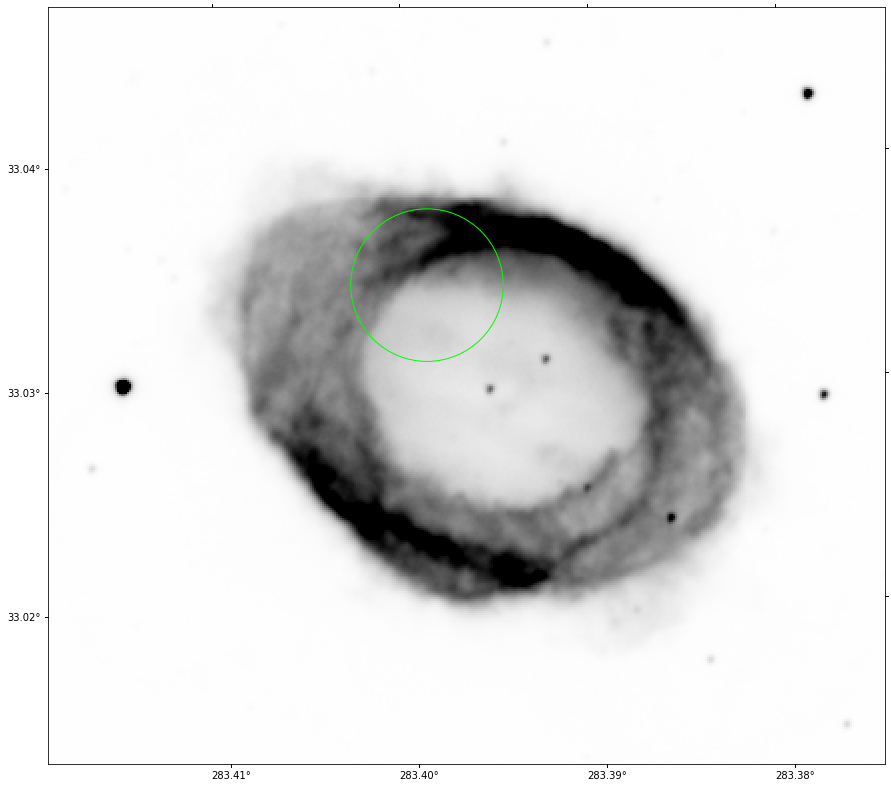

In [9]:
import pyregion

# draw the background image
deep_frame.imshow(cmap='gray_r', perc=99.9)
pl.xlim((550,970))
pl.ylim((650,1030))

# load region file and draw the regions
reg = pyregion.open('region.reg').as_imagecoord(cube.get_wcs_header())

ax = pl.gca()
patch_list, artist_list = reg.get_mpl_patches_texts()
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)
    

## Extract a spectrum of the region to define the fit parameters

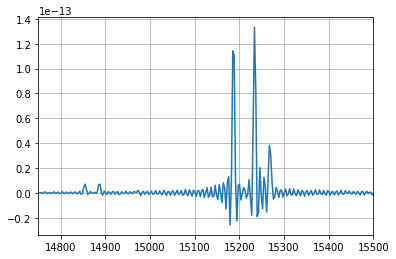

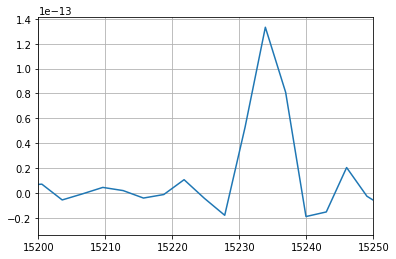

In [13]:
spectrum = cube.get_spectrum(749, 898, 3)

# all the spectrum
spectrum.plot()
pl.xlim((14750,15500))
pl.grid()

# zoom over Halpha
pl.figure()
spectrum.plot()
pl.xlim((15200,15250))
pl.grid()


In [14]:
# Halpha wavenumber is roughly 15235 cm-1 which gives a velocity :

import orb.utils.spectrum
from orb.core import Lines
vel = orb.utils.spectrum.compute_radial_velocity(15235, Lines().get_line_cm1('Halpha'), wavenumber=True)
print('velocity: {} km/s'.format(vel))

velocity: 46.329113734443276 km/s


master.11e5|WARNING| please set a guess, or a covarying value of sigma > 0 or use a  sinc model or you might end up with nans


=== Fit results ===
lines: ['[NII]6548', 'H3', '[NII]6584', '[SII]6717', '[SII]6731'], fmodel: sincgauss
iterations: 56, fit time: 2.67e-01 s
Velocity (km/s): [53.74(14) 62.98(15) 53.74(14) 53.74(14) 53.74(14)] 
Flux: [9.372(85)e-14 2.984(12)e-13 2.887(12)e-13 1.753(84)e-14 1.674(84)e-14]
Broadening (km/s): [15.61(54) 17.91(48) 15.61(54) 15.61(54) 15.61(54)]



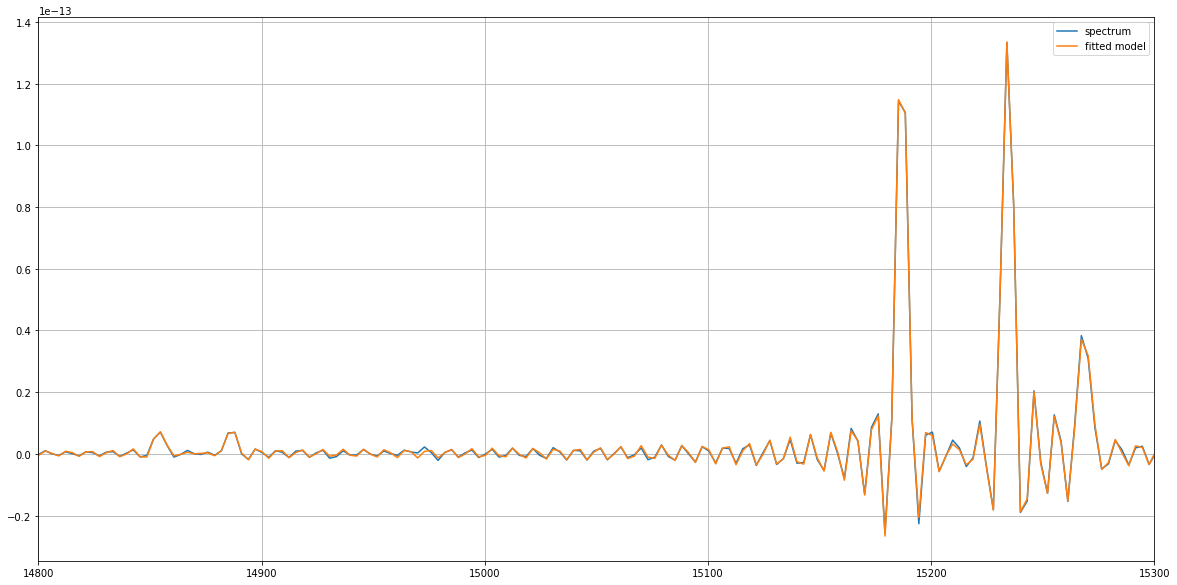

In [18]:
# set up the fit to check if before running the long extraction process over the whole ROI

fit = spectrum.fit(('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                   fmodel='sincgauss', 
                   pos_def=['1','2','1','1','1'], 
                   pos_cov=[vel, vel],
                   sigma_def=['1','2','1','1','1'],
                   sigma_cov=[20, 20],
                   snr_guess=None,
                   nofilter=True)

print(fit)
new_vel = fit['velocity'][0], fit['velocity'][1]
                                                 
pl.figure(figsize=(20,10))
spectrum.plot(label='spectrum')
fit.get_spectrum().plot(label='fitted model')
pl.xlim((14800,15300))
pl.legend()
pl.grid()

## Fit the ROI

We are ready to fit all the spectra in the defined ROI.

- On very high SNR data it's better to set snr_guess='auto' and use the bayesian fit mode even if it's longer since there are some instabilities on the classic fit due to the numerical computation of the jacobian. Note that a classical fit (snr_guess=None) will still give mostly relieable results although some pixels in the maps can be slightly biased with respect to their neighbourhood but the uncertainty will be a NaN so that they can be filtered.

- The guess on sigma must be small -- as small as the smaller sigma you expect -- but not too small (< 0.1 km/s). 1 km/s is a good guess. In theory we can expect a sigma of 0 km/s for unbroadened lines but the loss of modulation efficiency can broaden the line by a few km/s (see Baril et al. 2016 http://proceedings.spiedigitallibrary.org/proceeding.aspx?doi=10.1117/12.2232075 and Martin et al. 2016 http://cdsads.u-strasbg.fr/abs/2016MNRAS.463.4223M)

- Don't hesitate to fit binned data first, you will gain time and SNR which is a good way to check fitting errors.

-  warning: Jupyter can give an error (neverending fit process) if the fit below is done more than one time. Just restart the kernel as a workaround.

### 3x3 binning

In [1]:
# warning: Jupyter can give an error (neverending fit process) if the fit below is done more than one time. Just restart the kernel as a workaround and run the
# following cells before doing the fit
from orcs.process import SpectralCube
import pylab as pl
import orb.utils.io
import numpy as np

In [2]:
cube = SpectralCube('/home/thomas/local/M57_SN3.merged.cm1.1.0.hdf5', debug=False)

master.11e5|WARNING| both level2 and level3 in attrs
master.11e5|INFO| Cube is level 3
master.11e5|INFO| shape: (2048, 2064, 593)
master.11e5|INFO| wavenumber calibration: True
master.11e5|INFO| flux calibration: True
master.11e5|INFO| wcs calibration: True


In [3]:
new_vel = 50 # km/s
cube.fit_lines_in_region('region.reg',
        ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                   fmodel='sincgauss', 
                   pos_def=['1','2','1','1','1'], 
                   pos_cov=[new_vel, new_vel],
                   sigma_def=['1','2','1','1','1'],
                   sigma_cov=[20, 20],
                   snr_guess=None,
                   nofilter=True, binning=3)

master.11e5|INFO| Number of spectra to fit: 511
master.11e5|WARNING| please set a guess, or a covarying value of sigma > 0 or use a  sinc model or you might end up with nans
master.11e5|INFO| Init of the parallel processing server with 32 threads
master.11e5|INFO| passed mapped kwargs : []
master.11e5|INFO| 26 rows to fit
master.11e5|WARNING| /home/thomas/Astro/Python/ORB/Orb/orb/utils/image.py:1073: RuntimeWarning: Mean of empty slice
  return np.squeeze(np.nanmean(np.nanmean(im_view, axis=3), axis=1))



 [==========] [100%] [completed in 14.5 s]                                    

master.11e5|INFO| Closing parallel processing server


master.11e5|INFO| parallel processing closed
master.11e5|INFO| all maps saved as ./M57_SN3/MAPS/M57_SN3.LineMaps.maps.3x3.hdf5
master.11e5|INFO| Writing height maps
master.11e5|WARNING| param height is the same for all lines
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.all.3x3.height.fits in 0.01 s 
master.11e5|INFO| Writing height-err maps
master.11e5|WARNING| param height-err is the same for all lines
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.all.3x3.height-err.fits in 0.01 s 
master.11e5|INFO| Writing amplitude maps
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6548.3x3.amplitude.fits in 0.01 s 
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.amplitude.fits in 0.01 s 
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.3x3.amplitude.fits in 0.01 s 
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6716.3x3.amplitude.fits in 0.01 s 
ma

###  Check the results


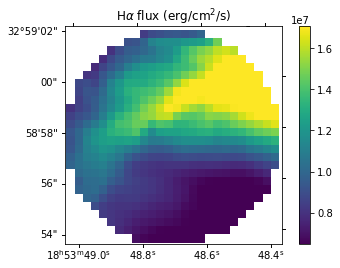

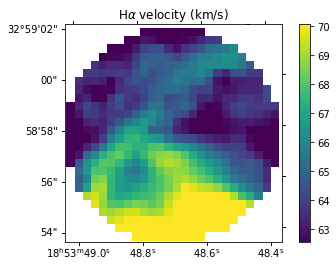

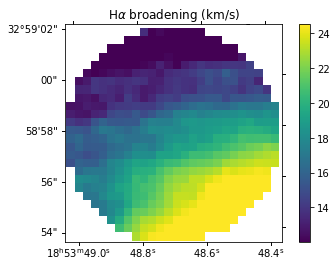

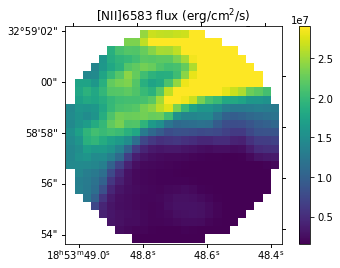

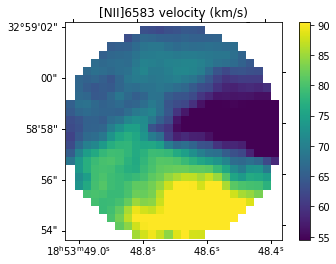

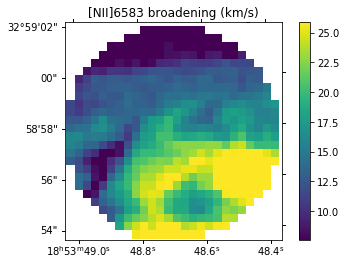

In [6]:
def show_map(path, title):
    fig = pl.figure()
    ax = fig.add_subplot(111, projection=cube.get_wcs())
    ax.coords[0].set_major_formatter('hh:mm:ss.s')
    ax.coords[1].set_major_formatter('dd:mm:ss')
    _map = orb.utils.io.read_fits(path)
    pl.imshow(_map.T, origin='bottom-left', 
              vmin=np.nanpercentile(_map, 10),
              vmax=np.nanpercentile(_map, 90))
    pl.xlim((700/3,780/3))
    pl.ylim((850/3,930/3))
    pl.colorbar()
    pl.title(title)
    
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.flux.fits', r'H$\alpha$ flux (erg/cm$^2$/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.velocity.fits', r'H$\alpha$ velocity (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.sigma.fits', r'H$\alpha$ broadening (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.3x3.flux.fits', r'[NII]6583 flux (erg/cm$^2$/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.3x3.velocity.fits', r'[NII]6583 velocity (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.3x3.sigma.fits', r'[NII]6583 broadening (km/s)')


### 1x1 binning

In [1]:
# warning: Jupyter can give an error (neverending fit process) if the fit below is done more than one time. Just restart the kernel as a workaround and run the
# following cells before doing the fit
from orcs.process import SpectralCube
import pylab as pl
import orb.utils.io
import numpy as np

In [2]:
cube = SpectralCube('/home/thomas/local/M57_SN3.merged.cm1.1.0.hdf5', debug=False)

master.11e5|WARNING| both level2 and level3 in attrs
master.11e5|INFO| Cube is level 3
master.11e5|INFO| shape: (2048, 2064, 593)
master.11e5|INFO| wavenumber calibration: True
master.11e5|INFO| flux calibration: True
master.11e5|INFO| wcs calibration: False


In [4]:
cube.fit_lines_in_region('region.reg',
        ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                   fmodel='sincgauss', 
                   pos_def=['1','2','1','1','1'], 
                   pos_cov=[50, 50],
                   sigma_def=['1','2','1','1','1'],
                   sigma_cov=[20, 20],
                   snr_guess=None,
                   nofilter=True, binning=1)

master.11e5|INFO| Number of spectra to fit: 4604
master.11e5|WARNING| please set a guess, or a covarying value of sigma > 0 or use a  sinc model or you might end up with nans
master.11e5|INFO| Init of the parallel processing server with 32 threads
master.11e5|INFO| passed mapped kwargs : []
master.11e5|INFO| 77 rows to fit


 [==========] [100%] [completed in 1m31s]                                     

master.11e5|INFO| Closing parallel processing server


master.11e5|INFO| parallel processing closed
master.11e5|INFO| all maps saved as ./M57_SN3/MAPS/M57_SN3.LineMaps.maps.1x1.hdf5
master.11e5|INFO| Writing height maps
master.11e5|WARNING| param height is the same for all lines
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.all.1x1.height.fits in 0.23 s 
master.11e5|INFO| Writing height-err maps
master.11e5|WARNING| param height-err is the same for all lines
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.all.1x1.height-err.fits in 0.16 s 
master.11e5|INFO| Writing amplitude maps
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6548.1x1.amplitude.fits in 0.16 s 
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.1x1.amplitude.fits in 0.16 s 
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.1x1.amplitude.fits in 0.16 s 
master.11e5|INFO| Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6716.1x1.amplitude.fits in 0.16 s 
ma

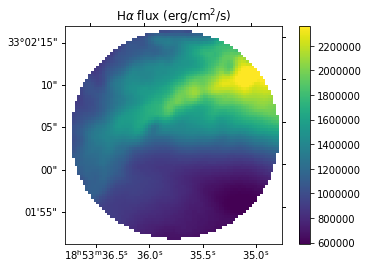

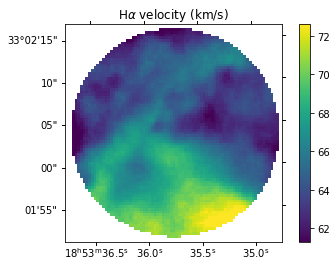

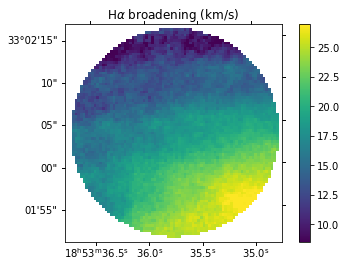

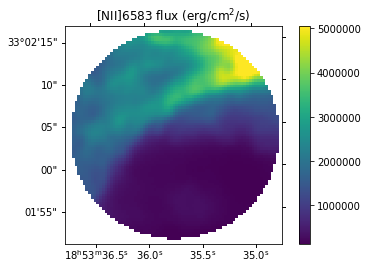

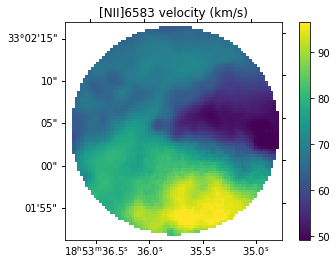

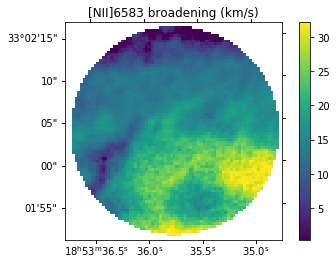

In [6]:
def show_map(path, title):
    fig = pl.figure()
    ax = fig.add_subplot(111, projection=cube.get_wcs())
    ax.coords[0].set_major_formatter('hh:mm:ss.s')
    ax.coords[1].set_major_formatter('dd:mm:ss')
    _map = orb.utils.io.read_fits(path)
    pl.imshow(_map.T, origin='bottom-left', 
              vmin=np.nanpercentile(_map, 1),
              vmax=np.nanpercentile(_map, 99))
    pl.xlim((700,780))
    pl.ylim((850,930))
    pl.colorbar()
    pl.title(title)
    
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.1x1.flux.fits', r'H$\alpha$ flux (erg/cm$^2$/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.1x1.velocity.fits', r'H$\alpha$ velocity (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.1x1.sigma.fits', r'H$\alpha$ broadening (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.1x1.flux.fits', r'[NII]6583 flux (erg/cm$^2$/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.1x1.velocity.fits', r'[NII]6583 velocity (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.1x1.sigma.fits', r'[NII]6583 broadening (km/s)')
